# Деревья решений

## Построение дерева

Опишем жадный алгоритм построения бинарного дерева решений:
1. Начинаем со всей обучающей выборки $X$, которую помещаем в корень $R_1$. 
2. Задаём функционал качества $Q(X, j, t)$ и критерий остановки. 
3. Запускаем построение из корня: $SplitNode(1, R_1)$

Функция $SplitNode(m, R_m)$
1. Если выполнен критерий остановки, то выход.
2. Находим наилучший с точки зрения $Q$ предикат: $j, t$: $[x_j<t]$
3. Помещаем предикат в вкршину и получаем с его помощью разбиение $X$ на две части: $R_{left} = \lbrace x|x_j<t \rbrace$ и $R_{right} = \lbrace x|x_j \geqslant t \rbrace$
4. Поместим $R_{left}$ и $R_{right}$ соответсвенно в левое и правое поддерево.
5. Рекурсивно повторяем $SplitNode(left, R_{left})$ и $SplitNode(right, R_{right})$.

В конце поставим в соответствие каждому листу ответ. Для задачи классификации - это самый частый среди объектов класс или вектор с долями классов (можно интерпретировать как вероятности):
$$ c_v = \arg \max_{k\in Y} \sum_{(x_i,y_i) \in R_v} [y_i=k]  $$

## Функционал качества для деревьев решений


Энтропия Шеннона для системы с N возможными состояниями определяется по формуле:
$$H = - \sum_{i=0}^{N} p_i\log_2p_i $$

где $p_i$ – вероятности нахождения системы в $i$-ом состоянии. 

Это очень важное понятие теории информации, которое позволяет оценить количество информации (степень хаоса в системе). Чем выше энтропия, тем менее упорядочена система и наоборот. С помощью энтропии мы формализуем функционал качества для разделение выборки (для задачи классификации).

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import random
from pprint import pprint

Код для расчёта энтропии:

In [ ]:
def entropy(y):
    
    _, counts = np.unique(y, return_counts=True)

    probabilities = counts / counts.sum()
    entropy = sum(probabilities * -np.log2(probabilities))
     
    return entropy

Здесь $y$ - это массив значений целевой переменной

Энтропия – по сути степень хаоса (или неопределенности) в системе. Уменьшение энтропии называют приростом информации (information gain, IG).

Обочначим $R_v$ - объекты, которые нужно разделить в помощью предиката в вершине $v$. Запишем формулу для расчёта информационного прироста:
$$ Q = IG = H(R_v) - (H(R_{left})+H(R_{right}))$$

На каждом шаге нам нужно максимизировать этот функционал качества. Как это делать? Например, так можно перебрать $t$ для выбранного $j$.

Предыдущая версия формулы прироста информации слишком упрощена. В работе необходимо использовать более устойчивую формулу, которая учитывает не только энтропию подмножеств, но и их размер. 

$$ Q = IG = H(R_v) - \Big (\frac{|R_{left}|} {|R_{v}|} H(R_{left})+ \frac{|R_{right}|} {|R_{v}|} H(R_{right})\Big)$$

где, $|R_{v}|$, $|R_{left}|$ и $|R_{right}|$ - количество элементов в соответствующих множествах.


### Задание 4.1

Реализуйте алгоритм построения дерева. Должны быть отдельные функции (методы) для расчёта энтропии (уже есть), для разделения дерева (используйте `pandas`), для подсчёта функционала качества $IG$, для выбора наилучшего разделения (с учетом признакоd и порогов), для проверки критерия остановки.

Для набора данных `iris` реализуйте алгоритм и минимум три из разными критерия остановки из перечисленных ниже:
* максимальной глубины дерева = 5
* минимального числа объектов в листе = 5
* максимальное количество листьев в дереве = 5
* purity (остановка, если все объекты в листе относятся к одному классу)

Реализуйте функцию `predict` (на вход функции подаётся датафрейм с объектами)

Оцените точность каждой модели с помощью метрики доля правильных ответов (`from sklearn.metrics import accuracy_score` или реализовать свою).

In [ ]:
from sklearn import datasets

iris_dataset = datasets.load_iris()

In [ ]:
df = pd.DataFrame(np.hstack((iris_dataset['data'], iris_dataset['target'][:, None])), columns=iris_dataset['feature_names'] + ['target'])
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
from collections import Counter
import random

random.seed(42)

In [ ]:
class Node():
    def __init__(self, *, feature=None, treshold=None, value=None, left=None, right=None):
        self.feature = feature
        self.treshold = treshold
        self.value = value
        self.left = left
        self.right = right

Критерии остановки:
- максимальнaя глубины дерева
- минимальное числа объектов в листе
- purity (остановка, если все объекты в листе относятся к одному классу)

In [ ]:
class DecisionTreeClassifier:
    def __init__(self,
                 max_depth = None,
                 min_samples_leaf = 2,
                 purity = True
                 ):
        self.purity = purity
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
  
    def _information_gain(self, lhs, rhs, total):
        return entropy(total) - (len(lhs)/len(total)*entropy(lhs) + len(rhs)/len(total)*entropy(rhs))
    
    def _split_node(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))
        if ((self.max_depth and depth >= self.max_depth)
            or (self.purity and n_labels == 1)
            or self.min_samples_leaf * 2 > n_samples):
            return Node(value=Counter(y.values).most_common(1)[0][0])
        
        columns = X.columns.values
            
        col, treshold = self._best_split(X, y, columns)
        
        if col is None:
            return Node(value=Counter(y.values).most_common(1)[0][0])
        
        ((lX, ly), (rX, ry)) = self._split(X, y, col, treshold)
        return Node(left=self._split_node(lX, ly, depth=depth + 1), right=self._split_node(rX, ry, depth=depth + 1), treshold=treshold, feature=col)
        
        
    
    def _best_split(self, X, y, columns):
        ig = -1
        best_col = None
        best_treshold = None
        for col in columns:
            for treshold in np.unique(X.values)[:-1]:
                ((_, ly), (_, ry)) = self._split(X, y, col, treshold)
                temp_ig = self._information_gain(ly, ry, y)
                if temp_ig > ig and len(ly) >= self.min_samples_leaf and len(ry) >= self.min_samples_leaf:
                    ig = temp_ig
                    best_col = col
                    best_treshold = treshold
        
        return best_col, best_treshold

    
    def _split(split, X, y, feature, treshold):
        mask = X[feature] <= treshold
        return ((X[mask], y[mask]), (X[~mask], y[~mask]))
    
    def fit(self, X, y):
        self._root = self._split_node(X,  y)

    def predict(self, X):
        if self._root is None:
            return None

        X = X.reset_index(drop=True)
        for row in range(X.shape[0]):
            node = self._root
            while node.value is None:
                test = X.iloc[row][node.feature] <= node.treshold
                node = node.left if test else node.right
            yield node.value

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
cols = df.columns.values
df_test = df.sample(int(len(df)*0.3), random_state=42)
df_train = df.drop(df_test.index)

In [ ]:
(len(df), len(df_test), len(df_train))

(150, 45, 105)

In [ ]:
X_train, y_train, X_test, y_test = df_train[cols[: -1]], df_train[cols[-1]], df_test[cols[: -1]], df_test[cols[-1]]

In [ ]:
my_tree = DecisionTreeClassifier(max_depth=5, purity=False, min_samples_leaf=1)
my_tree.fit(X_train, y_train)
y_pred = list(my_tree.predict(X_train))
print(f'Train accuracy only depth: {accuracy_score(y_train, y_pred):.4f}')
y_pred = list(my_tree.predict(X_test))
print(f'Test accuracy only depth: {accuracy_score(y_test, y_pred):.4f}')

Train accuracy only depth: 0.9905
Test accuracy only depth: 0.9111


In [ ]:
my_tree = DecisionTreeClassifier(min_samples_leaf=5, purity=False)
my_tree.fit(X_train, y_train)
y_pred = list(my_tree.predict(X_train))
print(f'Train accuracy only samples: {accuracy_score(y_train, y_pred):.4f}')
y_pred = list(my_tree.predict(X_test))
print(f'Test accuracy only samples: {accuracy_score(y_test, y_pred):.4f}')

Train accuracy only samples: 0.9619
Test accuracy only samples: 1.0000


In [ ]:
my_tree = DecisionTreeClassifier(purity=True, min_samples_leaf=1)
my_tree.fit(X_train, y_train)
y_pred = list(my_tree.predict(X_train))
print(f'Train accuracy only purity: {accuracy_score(y_train, y_pred):.4f}')
y_pred = list(my_tree.predict(X_test))
print(f'Test accuracy only purity: {accuracy_score(y_test, y_pred):.4f}')

Train accuracy only purity: 1.0000
Test accuracy only purity: 0.9111


In [ ]:
my_tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=5)
my_tree.fit(X_train, y_train)
y_pred = list(my_tree.predict(X_train))
print(f'Train accuracy: {accuracy_score(y_train, y_pred):.4f}')
y_pred = list(my_tree.predict(X_test))
print(f'Test accuracy: {accuracy_score(y_test, y_pred):.4f}')

Train accuracy: 0.9619
Test accuracy: 1.0000


In [ ]:
from sklearn.tree import DecisionTreeClassifier as SklearnTreeClassifier

In [ ]:
sklearn_tree = SklearnTreeClassifier(max_depth=5, min_samples_leaf=5, criterion='entropy')
sklearn_tree.fit(X_train, y_train)
y_pred = list(sklearn_tree.predict(X_train))
print(f'Train accuracy sklearn: {accuracy_score(y_train, y_pred):.4f}')
y_pred = list(sklearn_tree.predict(X_test))
print(f'Test accuracy sklearn: {accuracy_score(y_test, y_pred):.4f}')

Train accuracy sklearn: 0.9619
Test accuracy sklearn: 1.0000


**Вывод**: Все критерии остановки показали схожие результаты, но на purity и max_depth видно явное переобучение, лучше всех же себя показал min_samples_leaf. На моделе со всеми критериями acuracy одинаковая как при использовании самописного дерева решений, так и реализации из scikit learn 

##  Случайный лес

Опишем алгоритм случайный лес (*random forest*) и попутно разберём основные идеи:

1. Зададим $N$ - число деревьев в лесу.
2. Для каждого $n$ из $N$ сгенерируем свою выборку $X_n$. Пусть $m$ - это количество объектов в $X$. При генерации каждой $X_n$ мы будем брать объекты $m$ раз с возвращением. То есть один и тот же объект может попасть в выборку несколько раз, а какие-то объекты не попадут. (Этот способ назвается бутстрап).
3. По каждой $X_n$ построим решающее дерево $b_n$. Обычно стараются делать глубокие деревья. В качестве критериев остановки можно использовать `max_depth` или `min_samples_leaf` (например, пока в каждом листе не окажется по одному объекту). При каждом разбиении сначала выбирается $k$ (эвристика $k = \sqrt d$, где $d$ - это число признаков объектов из выборки $X$) случайных признаков из исходных, и оптимальное разделение выборки ищется только среди них. Обратите внимание, что мы не выбрасываем оставшиеся признаки!
4. Итоговый алгоритм будет представлять собой результат голосования (для классификации) и среднее арифметическое (для регрессии). Модификация алгоритма предполагает учёт весов каждого отдельного слабого алгоритма в ансамбле, но в этом особо нет смысла.


### Задание 4.2

В качестве набора данных используйте: https://www.kaggle.com/mathchi/churn-for-bank-customers

Там есть описание и примеры работы с этими данными. Если кратко, речь идёт про задачу прогнозирования оттока клиентов. Есть данные о 10 тысячах клиентов банка, часть из которых больше не являются клиентами.

Используя либо свою реализацию, либо  `DecisionTreeClassifier` с разными настройками из `sklearn.tree` реализйте алгоритм "случайный лес". 

Найдите наилучшие гиперпараметры этого алгоритма: количество деревьев, критерий остановки, функционал качества, минимальное количество объектов в листьях и другие.

Нельзя использовать готовую реализацию случайного леса из `sklearn`.

В подобных задачах очень важна интерпретируемость алгоритма. Попытайтесь оценить информативность признаков, т.е. ответить а вопрос, значения каких признаков являются самыми важными индикаторами того, что банк потеряет клиента.

In [ ]:
df = pd.read_csv('./churn.csv', index_col='RowNumber')

#### Data Processing

In [ ]:
df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Сразу дропнем фамилии.

In [ ]:
df = df.drop('Surname', axis=1)

In [ ]:
df.dtypes

CustomerId           int64
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [ ]:
np.unique(df.Gender)

array(['Female', 'Male'], dtype=object)

Датасет не политкорректный) Переведем gender в bool.

In [ ]:
df.Gender = (df.Gender == 'Male')

С деревьми One-Hot Encoding работает плохо при больщом количестве рзличных вариатов, посмотрим на отношение колличества различных Geography к общему колличеству строк.

In [ ]:
len(np.unique(df.Geography)) / df.shape[0]

0.0003

0.0003, смысл в one-hot encoding имеется

In [ ]:
df = pd.get_dummies(df, columns=['Geography'])

Ну и напоследок проверим Nan

In [ ]:
df.isna().sum()

CustomerId           0
CreditScore          0
Gender               0
Age                  0
Tenure               0
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
Geography_France     0
Geography_Germany    0
Geography_Spain      0
dtype: int64

In [ ]:
df.head()

,CustomerId,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain
RowNumber,,,,,,,,,,,,,,
1,15634602,619,False,42,2,0.00,1,1,1,101348.88,1,1,0,0
2,15647311,608,False,41,1,83807.86,1,0,1,112542.58,0,0,0,1
3,15619304,502,False,42,8,159660.80,3,1,0,113931.57,1,1,0,0
4,15701354,699,False,39,1,0.00,2,0,0,93826.63,0,1,0,0
5,15737888,850,False,43,2,125510.82,1,1,1,79084.10,0,0,0,1


In [ ]:
df.shape

(10000, 14)

In [ ]:
type(df)

pandas.core.frame.DataFrame

In [ ]:
X, y = df.drop('Exited', axis=1).to_numpy(), df.Exited.to_numpy()

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#### Model

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from itertools import repeat

In [ ]:
class RandomForestClassifier(BaseEstimator):
    def __init__(self, n_estimators=100, *,
                 criterion='gini',
                 max_depth=None,
                 min_samples_leaf=1,
                 max_leaf_nodes=None,
                 max_features='sqrt'):
        self.max_features = max_features
        self.n_estimators = n_estimators
        self.criterion = criterion
        self.max_depth = max_depth
        self.max_leaf_nodes = max_leaf_nodes
        self.min_samples_leaf = min_samples_leaf
    
    def fit(self, X, y):        
        self._estimators = []
        importances = []
        for i in range(self.n_estimators):
            estimator = DecisionTreeClassifier(criterion=self.criterion, max_features=self.max_features, max_depth=self.max_depth, min_samples_leaf=self.min_samples_leaf, max_leaf_nodes=self.max_leaf_nodes)
            idxs = random.choices(range(X.shape[0]), k=X.shape[0])
            estimator.fit(X[idxs], y[idxs])
            importances.append(estimator.feature_importances_)
            self._estimators.append(estimator)
        self.feature_importances_ = np.mean(importances, axis=0)
        return self
    
    def predict(self, X):
        predictions = []
        for estimator in self._estimators:
            predictions.append(estimator.predict(X))
            
        predictions = np.transpose(predictions)
        return np.squeeze([Counter(vote).most_common(1)[0][0] for vote in predictions])
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)
    
    def get_params(self, deep=True):
        return {'criterion' : self.criterion,
                'max_features' : self.max_features,
                'max_depth' : self.max_depth,
                'min_samples_leaf' : self.min_samples_leaf,
                'max_leaf_nodes' : self.max_leaf_nodes}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

#### Model Training

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
estimator = RandomForestClassifier()
search = GridSearchCV(estimator, param_grid=
                      {
                          'criterion' : ['gini', 'entropy'],
                          'n_estimators' : [200, 250, 300, 350, 400],
                          'max_features' : ['sqrt', 'log2'],
                          'max_depth' : [200, 250, 300, 350, 400],
                          'min_samples_leaf' : [5, 10, 15, 20, 25],  
                      }, cv =5, n_jobs=20, verbose=10, refit=True)

search.fit(X_train, y_train)
print(search.best_params_)
print(f'Train  {search.score(X_train, y_train):.4f}')
print(f'Test   {search.score(X_test, y_test):.4f}')

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
{'criterion': 'entropy', 'max_depth': 350, 'max_features': 'log2', 'min_samples_leaf': 5, 'n_estimators': 200}
Train  0.9190
Test   0.8697


In [ ]:
lables = df.drop('Exited', axis=1).columns.values
importance = search.best_estimator_.feature_importances_

In [ ]:
pd.DataFrame(data = np.c_[lables, importance], columns = ["Feature", "Importance"]).sort_values(by = "Importance", ascending = False)

,Feature,Importance
3,Age,0.246037
6,NumOfProducts,0.151454
5,Balance,0.116893
9,EstimatedSalary,0.102624
0,CustomerId,0.098687
1,CreditScore,0.098329
4,Tenure,0.061062
8,IsActiveMember,0.042551
11,Geography_Germany,0.026648
2,Gender,0.020746


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

plt.rcParams["figure.figsize"] = (40, 10)

<BarContainer object of 13 artists>

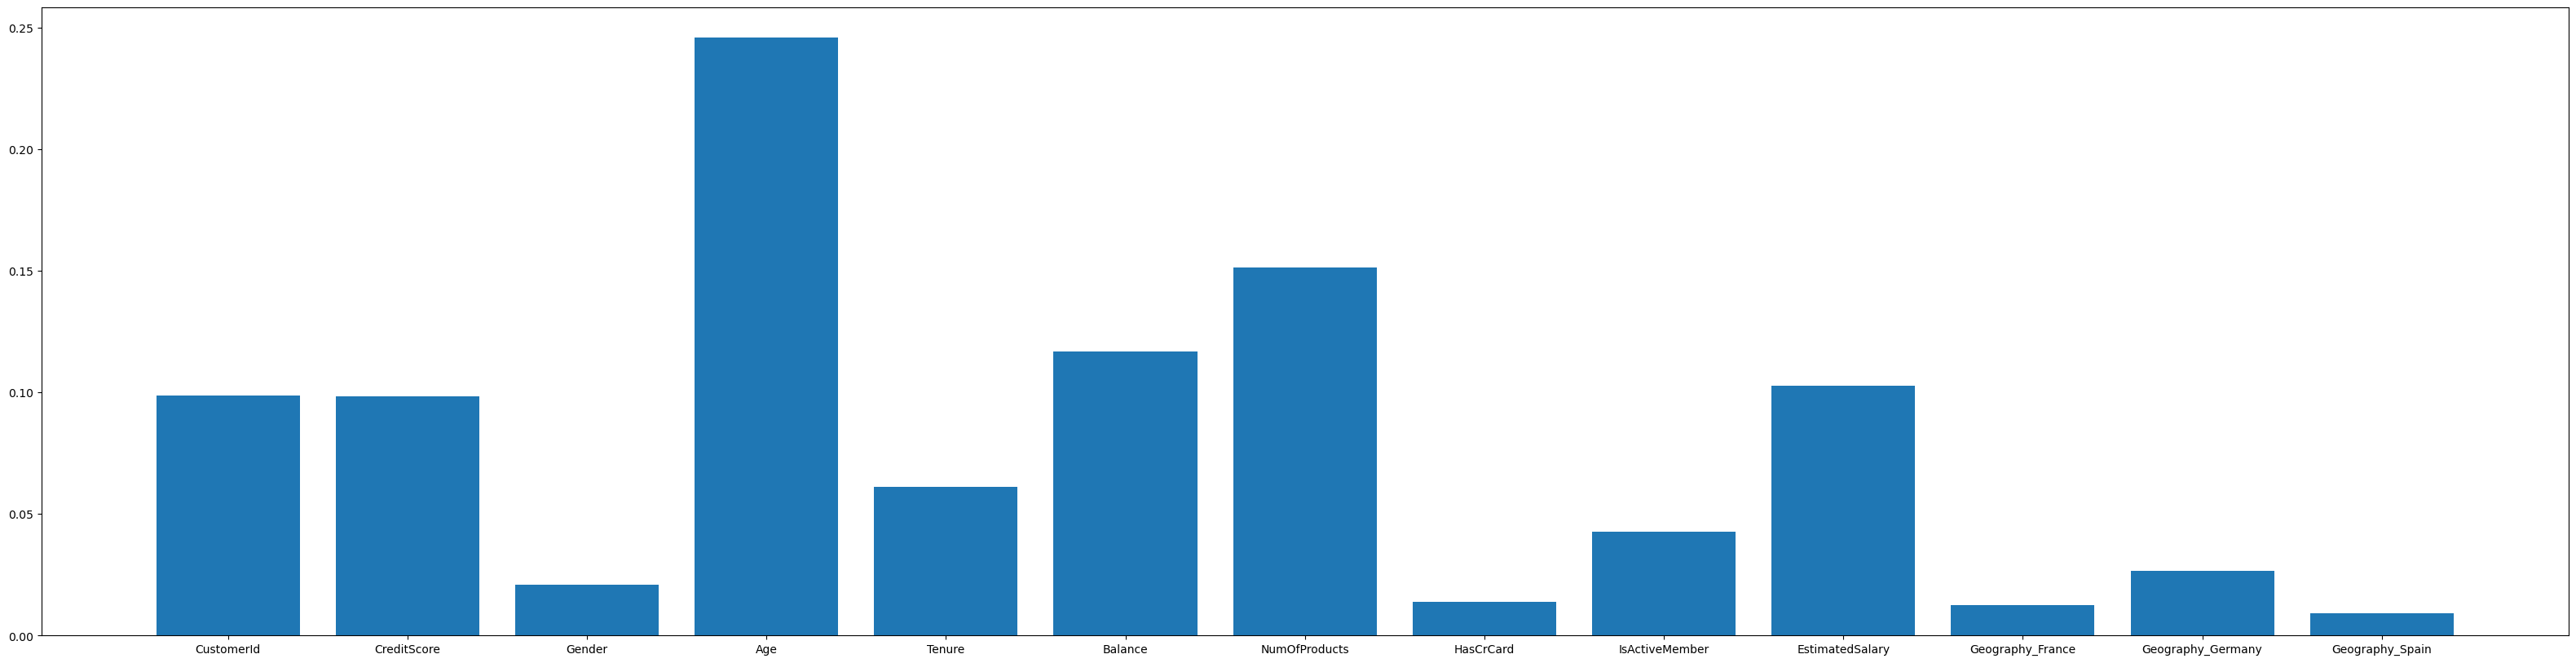

In [ ]:
plt.bar(lables, importance)

#### Scikit Learn Model

In [ ]:
from sklearn.ensemble import RandomForestClassifier as RandomForestClassifier

In [ ]:
sklearnForest = RandomForestClassifier()
sklearnForest.set_params(**search.best_params_)
sklearnForest.fit(X_train, y_train)
print(f'Train  {sklearnForest.score(X_train, y_train):.4f}')
print(f'Test   {sklearnForest.score(X_test, y_test):.4f}')

Train  0.9082
Test   0.8694


### Вывод

На тестовой выборке реализацией из scikit learn хуже самописой на 0.9% accuracy. На тестовой выборке же разницв составляет всего лишь 0.03% в пользу самописной реализации